### Flash PL bitstream onto FPGA

In [1]:
from pynq import allocate, Overlay;
import numpy as np;
import matplotlib.pyplot as plot;
from PIL import Image as pil;

# Laad systeemcomponenten in PL

system = Overlay("bd_wrapper.bit");
dma = system.axi_dma_0;
resizer = system.resize_accel_0;

# Check if the VPU IP core is the right component by chekcing if the registers exist

for reg in ["in_width", "in_height"]:
    assert(hasattr(resizer.register_map, reg));

resizer.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, RESERVED_3=0, RESERVED_4=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0, CHAN2_INT_EN=0, RESERVED_1=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0, CHAN2_INT_ST=0, RESERVED_1=0),
  in_height = Register(in_height=write-only),
  in_width = Register(in_width=write-only)
}

### Load input image

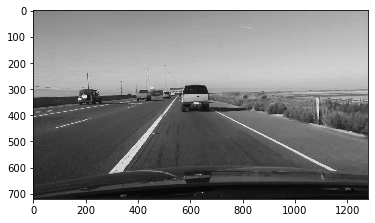

In [2]:
# Laad input image

image = pil.open("0a0a0b1a-7c39d841.grayscale.png");

plot.imshow(image, cmap='gray');

### Allocate SDRAM space & copy image to there

In [3]:
# Wijs SDRAM toe waar wij de afbeelding willen plaatsen

width, height = image.size

in_buffer = allocate(shape=(height, width, 3), 
                            dtype=np.uint8, cacheable=1)
out_buffer = allocate(shape=(height, width, 3), 
                             dtype=np.uint8, cacheable=1)

# Kopieer de afbeelding naar deze ruimte

in_buffer[:] = np.array(image)

### Activate the HLS Image Processing IP Core

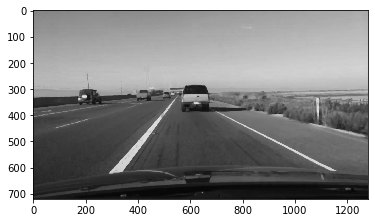

In [4]:
# Geef een commando aan de digitale logica via de S_AXILITE poort

resizer.register_map.in_width = width
resizer.register_map.in_height = height

dma.sendchannel.transfer(in_buffer)
dma.recvchannel.transfer(out_buffer)    
resizer.write(0x00,0x81) # start
dma.sendchannel.wait()
dma.recvchannel.wait()

output = pil.fromarray(out_buffer)
output.save("0a0a0b1a-7c39d841.out.png")
plot.imshow(output)

In [5]:
del in_buffer
del out_buffer